In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import os
import gc
import json
from scipy.optimize import curve_fit
import datetime
from pathlib import Path

import plotly.express as px
from urllib.request import urlopen



In [2]:
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 50)

In [3]:
df = pd.read_csv('https://query.data.world/s/keax53lpqwffhayvcjmowjiydtevwo', parse_dates=['REPORT_DATE']).copy()


In [4]:
df.head()

,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
0,1043,NaN,Nova Scotia,2020-05-18,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,3,55
1,8,NaN,Saskatchewan,2020-03-20,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,0,0
2,0,NaN,Nunavut,2020-06-22,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,0,0
3,0,NaN,Nunavut,2020-09-10,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,0,0
4,261,NaN,Newfoundland and Labrador,2020-06-16,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,0,3


In [5]:
print("date range: {0} to {1}".format(df['REPORT_DATE'].min(), df['REPORT_DATE'].max()))

date range: 2019-12-31 00:00:00 to 2020-10-17 00:00:00


In [6]:
print(df.columns)

Index(['PEOPLE_POSITIVE_CASES_COUNT', 'COUNTY_NAME', 'PROVINCE_STATE_NAME',
       'REPORT_DATE', 'CONTINENT_NAME', 'DATA_SOURCE_NAME',
       'PEOPLE_DEATH_NEW_COUNT', 'COUNTY_FIPS_NUMBER', 'COUNTRY_ALPHA_3_CODE',
       'COUNTRY_SHORT_NAME', 'COUNTRY_ALPHA_2_CODE',
       'PEOPLE_POSITIVE_NEW_CASES_COUNT', 'PEOPLE_DEATH_COUNT'],
      dtype='object')


# Population Normed Comparisons

In [8]:
df_countrypop = pd.read_csv('/Users/dcripe/dev/code/notebooks/data_common/world_pop_2020.csv')

In [11]:
df_cp = df.groupby(['REPORT_DATE','COUNTRY_SHORT_NAME']).sum()[
    [
        'PEOPLE_POSITIVE_CASES_COUNT', 
        'PEOPLE_POSITIVE_NEW_CASES_COUNT', 
        'PEOPLE_DEATH_COUNT', 
        'PEOPLE_DEATH_NEW_COUNT'
    ]
];
df_cp['MORTALITY_RATIO'] = df_cp['PEOPLE_DEATH_COUNT']/df_cp['PEOPLE_POSITIVE_CASES_COUNT'];
df_cp = df_cp.unstack().copy();

In [12]:
df_cppop = df_cp.iloc[-5:-1].max().swaplevel(0,1).unstack().merge(df_countrypop[['country_code','population', 'country']], left_index=True, right_on='country').set_index('country')
df_cppop_lg = df_cppop[df_cppop['population'] > 10000000]

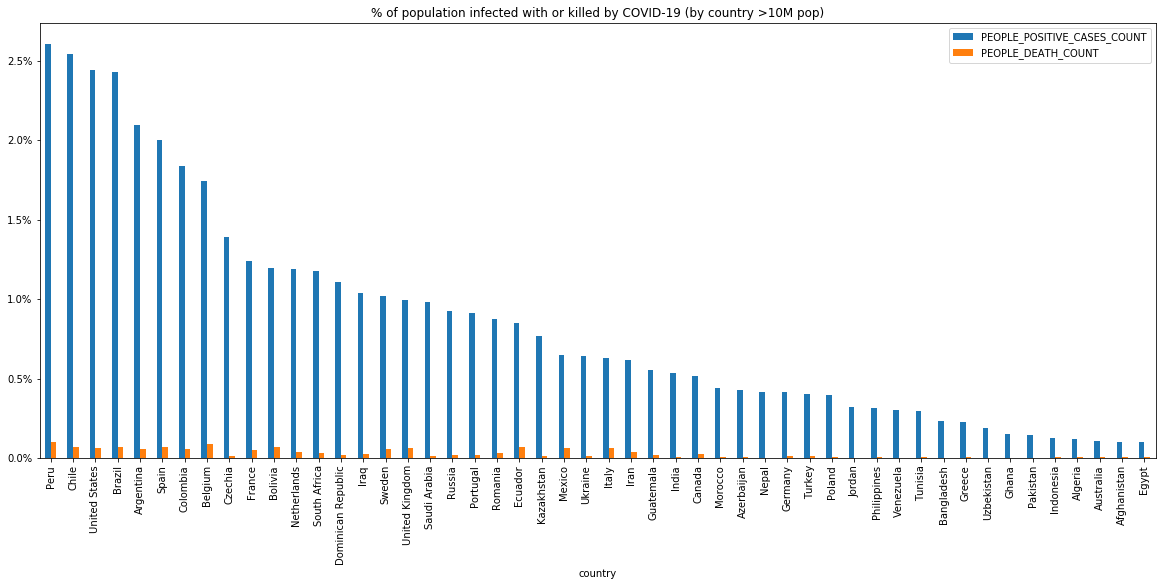

In [13]:
ax = df_cppop_lg[df_cppop_lg.columns[0:4]].div(df_cppop_lg['population'], axis=0)[['PEOPLE_POSITIVE_CASES_COUNT','PEOPLE_DEATH_COUNT']].sort_values(ascending=False, by='PEOPLE_POSITIVE_CASES_COUNT')[0:50].plot.bar(
    figsize=(20,8), 
    title="% of population infected with or killed by COVID-19 (by country >10M pop)",
#     stacked=True,
#     logy=True
#     icons='child', 
#     icon_size=18, 
#     icon_legend=True,
);
vals = ax.get_yticks();
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals]);

The chart below shows the "mortality" of COVID-19 by region.  The very wide range of mortality could be due to very different potency of the virus in different regions (unlikely), differences in testing and reporting accuracy (more likely) or lag (since fatalities happen days or weeks after infection).  Germany seems to have the most robust testing and reporting system at the moment and their mortality rate hovers between 4-5%. 

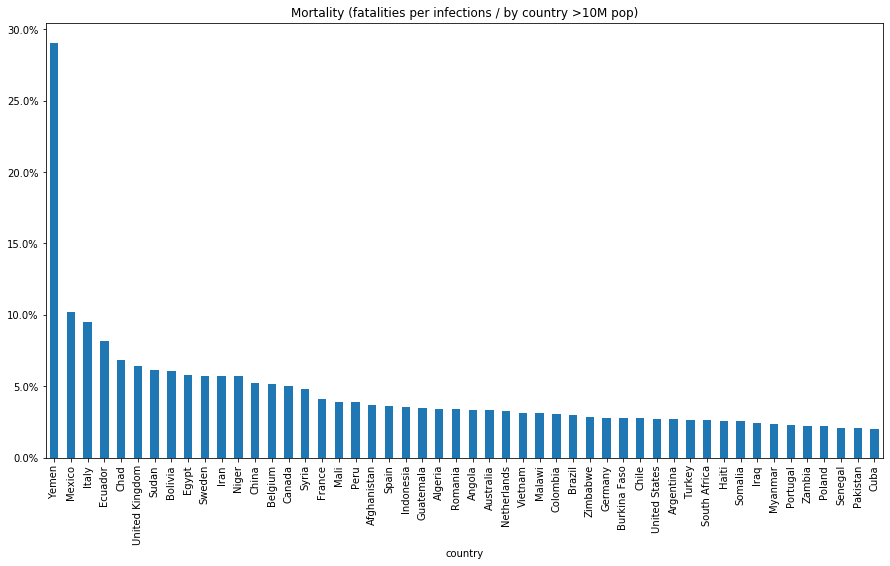

In [15]:
ax = (df_cppop_lg['PEOPLE_DEATH_COUNT']/df_cppop_lg['PEOPLE_POSITIVE_CASES_COUNT']).sort_values(ascending=False)[0:50].plot.bar(
    figsize=(15,8), 
    title="Mortality (fatalities per infections / by country >10M pop)"
);
vals = ax.get_yticks();
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals]);

# infected population

In [16]:
per_x = 100000

In [22]:
top_10c = df_cp.xs('PEOPLE_POSITIVE_CASES_COUNT', axis=1, level=0).iloc[-5:-1].max().sort_values(ascending=False)[0:10].index.values
top_25c = df_cp.xs('PEOPLE_POSITIVE_CASES_COUNT', axis=1, level=0).iloc[-5:-1].max().sort_values(ascending=False)[0:25].index.values

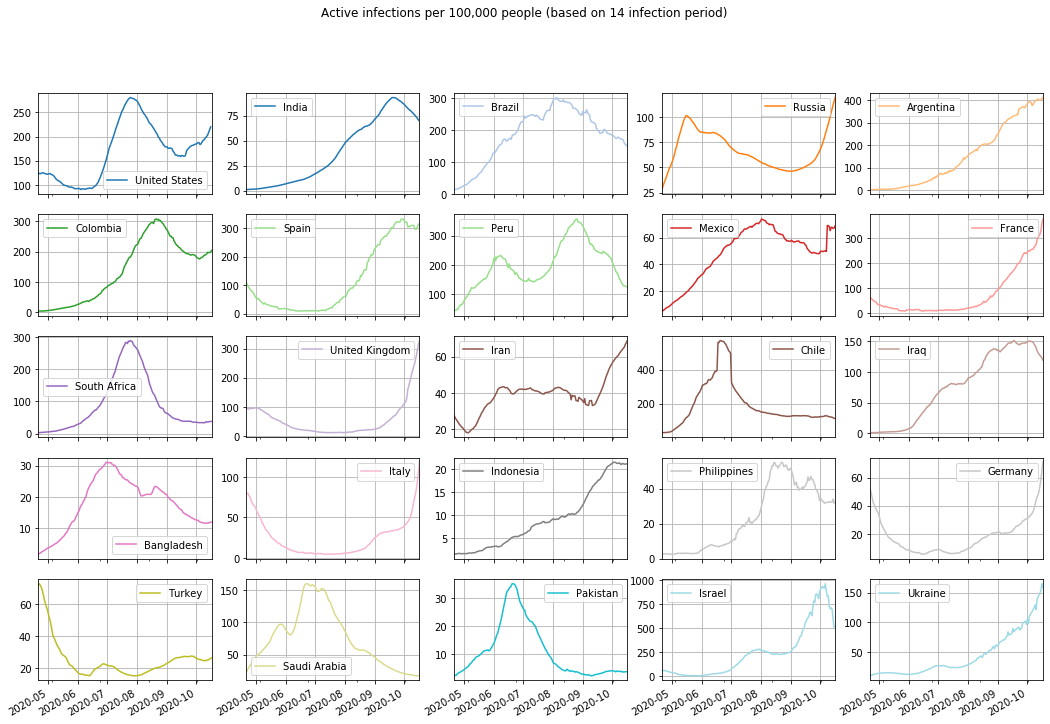

In [23]:
# df_trc = df.groupby(['Date','Country_Region','Case_Type']).agg({'Cases':sum,'Population_Count':sum})

df_rinfc = df_cp.xs('PEOPLE_POSITIVE_NEW_CASES_COUNT', axis=1, level=0)[top_25c].rolling(window=14).sum().iloc[-180::].T.merge(
    df_countrypop[['country_code','population', 'country']], left_index=True, right_on='country').set_index('country')

(df_rinfc[df_rinfc.columns[0:-2]].div(df_rinfc[df_rinfc.columns[-1]], axis=0)*per_x).T.plot(
    subplots=True, 
#     ylim=(0.01,50),
#     logy=True,
    grid=True, 
    layout=(5,5), 
    figsize=(18,12), 
    cmap='tab20',
    title='Active infections per {0:,} people (based on 14 infection period)'.format(per_x)
);

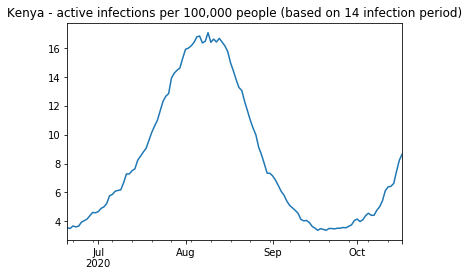

In [21]:
df_rinfc = df_cp.xs('PEOPLE_POSITIVE_NEW_CASES_COUNT', axis=1, level=0).rolling(window=14).sum().iloc[-120::].T.merge(
    df_countrypop[['country_code','population', 'country']], left_index=True, right_on='country').set_index('country')
df_rinfc_perx = (df_rinfc[df_rinfc.columns[0:-2]].div(df_rinfc[df_rinfc.columns[-1]], axis=0)*per_x)
df_rinfc_perx.loc['Kenya'].plot.line(title='Kenya - active infections per {0:,} people (based on 14 infection period)'.format(per_x))